# Code: CMPT 459 Final Group Assignment 

<h2>Table of Contents</h2>

* [1. Data Visualization](#chapter1)
    <!-- * [Section 1.1](#section_1_1) -->
* [2. Data Preprocessing](#chapter2)
    <!-- * [Section 2.1](#section_2_1)
        * [Sub Section 2.1.1](#sub_section_2_1_1)
        * [Sub Section 2.1.2](#sub_section_2_1_2) -->
* [3. Feature Selection](#chapter3)
    <!-- * [Section 3.1](#section_3_1)
        * [Sub Section 3.1.1](#sub_section_3_1_1)
        * [Sub Section 3.1.2](#sub_section_3_1_2) -->
    <!-- * [Section 3.2](#section_3_2) -->
* [4. Mapping the Features](#chapter4)
    <!-- * [Section 4.1](#section_3_1)
        * [Sub Section 3.1.1](#sub_section_4_1_1)
        * [Sub Section 3.1.2](#sub_section_4_1_2)
    * [Section 4.2](#section_4_2)
        * [Sub Section 3.2.1](#sub_section_4_2_1) -->
* [5. Balancing the Classes in the Training Dataset](#chapter5)
* [6. Building Models and Hyperparameter Tuning](#chapter6)
    * [6.1 KNN](#section_6_1)
        * [6.1.0 Model Implementation](#sub_section_6_1_0)
        * [6.1.1 Training The Model](#sub_section_6_1_1)
        * [6.1.2 Hyperparameter Tuning](#sub_section_6_1_2)
    * [6.2 Random Forest](#section_6_2)
        * [6.2.0 Model Implementation](#sub_section_6_2_0)
        * [6.2.1 Training The Model](#sub_section_6_2_1)
        * [6.2.2 Hyperparameter Tuning](#sub_section_6_2_2)
    * [6.3 Naive Bayes](#section_6_3)
        * [6.3.0 Model Implementation](#sub_section_6_3_0)
        * [6.3.1 Training The Model](#sub_section_6_3_1)
        * [6.3.2 Hyperparameter Tuning](#sub_section_6_3_2)
* [7. Overfitting](#chapter7)
    * [7.1 KNN](#section_7_1)
    * [7.2 Random Forest](#section_7_2)
    * [7.3 Naive Bayes](#section_7_3)
* [8. Prediction on Test set](#chapter8)

## 1. Data Visualization <a class="anchor" id="chapter1"></a>

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import matplotlib.colors as mcolors
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestClassifier
from mpl_toolkits.basemap import Basemap
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from imblearn.over_sampling import RandomOverSampler # Make sure to run pip install -U imbalanced-learn to run

ImportError: cannot import name 'plot_confusion_matrix' from 'sklearn.metrics' (/home/colton/.local/lib/python3.8/site-packages/sklearn/metrics/__init__.py)

In [69]:
locations_df = pd.read_csv('Steps-1-2-3/data/location_2021.csv')
cases_train_df = pd.read_csv('Steps-1-2-3/data/cases_2021_train.csv')
cases_test_df = pd.read_csv('Steps-1-2-3/data/cases_2021_test.csv')
countries_continents_df = pd.read_csv('Extra_Datasets/Countries by continents.csv')
population_df = pd.read_csv('Extra_Datasets/world_population.csv')


In [70]:
location_countries = set(locations_df['Country_Region'].unique())
population_countries = set(population_df['Country/Territory'].unique())

in_location_not_population = location_countries - population_countries
print("In 'location_df' but not in 'population_df':", in_location_not_population)

in_population_not_location = population_countries - location_countries
print("In 'population_df' but not in 'location_df':", in_population_not_location)

outcome_counts_age = cases_train_df['age'].sort_values(ascending=True)
print("outcome_counts_age")
print(outcome_counts_age.head(50))

non_nan_count = cases_train_df['age'].notnull().sum()
hyphen_count = cases_train_df['age'].astype(str).str.contains('-').sum()

print("hyphen_count")
print(non_nan_count, hyphen_count)

In 'location_df' but not in 'population_df': {'US', 'Congo (Kinshasa)', 'Holy See', 'Congo (Brazzaville)', 'Kosovo', 'Burma', 'MS Zaandam', 'Cabo Verde', 'Korea, South', 'West Bank and Gaza', 'Summer Olympics 2020', 'Diamond Princess', 'Czechia', 'Taiwan*', "Cote d'Ivoire"}
In 'population_df' but not in 'location_df': {'Guadeloupe', 'French Polynesia', 'New Caledonia', 'Macau', 'Cape Verde', 'Hong Kong', 'Gibraltar', 'Wallis and Futuna', 'Guam', 'Bermuda', 'Vatican City', 'Curacao', 'Cook Islands', 'Turks and Caicos Islands', 'Anguilla', 'Sint Maarten', 'Republic of the Congo', 'United States Virgin Islands', 'Ivory Coast', 'Faroe Islands', 'Aruba', 'Saint Barthelemy', 'Falkland Islands', 'South Korea', 'North Korea', 'Palestine', 'Northern Mariana Islands', 'Guernsey', 'Reunion', 'Western Sahara', 'Saint Martin', 'American Samoa', 'Isle of Man', 'Czech Republic', 'Tokelau', 'British Virgin Islands', 'Taiwan', 'Nauru', 'DR Congo', 'Myanmar', 'Mayotte', 'Tuvalu', 'United States', 'Green

In [71]:
country_name_mapping = {
    "Ivory Coast": "Cote d'Ivoire",
    "DR Congo": "Congo (Kinshasa)",
    "Republic of the Congo": "Congo (Brazzaville)",
    "South Korea": "Korea, South",
    "United States": "US",
    "Cape Verde": "Cabo Verde",
    "Myanmar": "Burma",
    "Czech Republic": "Czechia",
    "Taiwan": "Taiwan*",
    "Vatican City": "Holy See",
    "Palestine": "West Bank and Gaza"
}

In [72]:
# Apply mapping to population_df
population_df['Country/Territory'] = population_df['Country/Territory'].replace(country_name_mapping)

In [73]:
country_confirmed_sum = locations_df.groupby('Country_Region')['Confirmed'].sum().reset_index()
location_with_pop_df = country_confirmed_sum.merge(population_df, left_on='Country_Region',
                                                   right_on='Country/Territory', how='left')
location_with_pop_df['Confirmed_per_country'] = location_with_pop_df['Confirmed'] / location_with_pop_df[
    '2022 Population']

print("location_with_pop_df.groupby('Country_Region')['Confirmed'].sum().sort_values(ascending=False)")

location_with_pop_df.groupby('Country_Region')['Confirmed'].sum().sort_values(ascending=False)


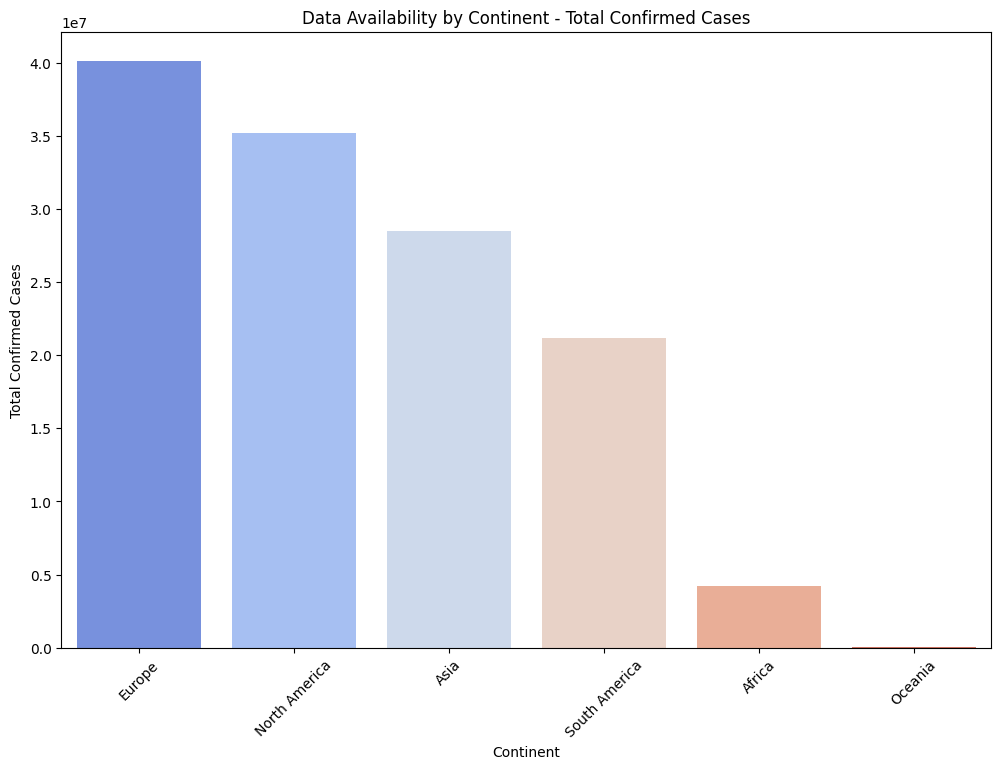

In [74]:
# Calculate data availability by continent using total confirmed cases.
continent_confirmed = location_with_pop_df.groupby('Continent')['Confirmed'].sum().sort_values(ascending=False)

# Visualize data availability by continent with a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=continent_confirmed.index, y=continent_confirmed.values, palette="coolwarm",
            hue=continent_confirmed.index, dodge=False)
plt.title('Data Availability by Continent - Total Confirmed Cases')
plt.xlabel('Continent')
plt.ylabel('Total Confirmed Cases')
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_5723/1568160814.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


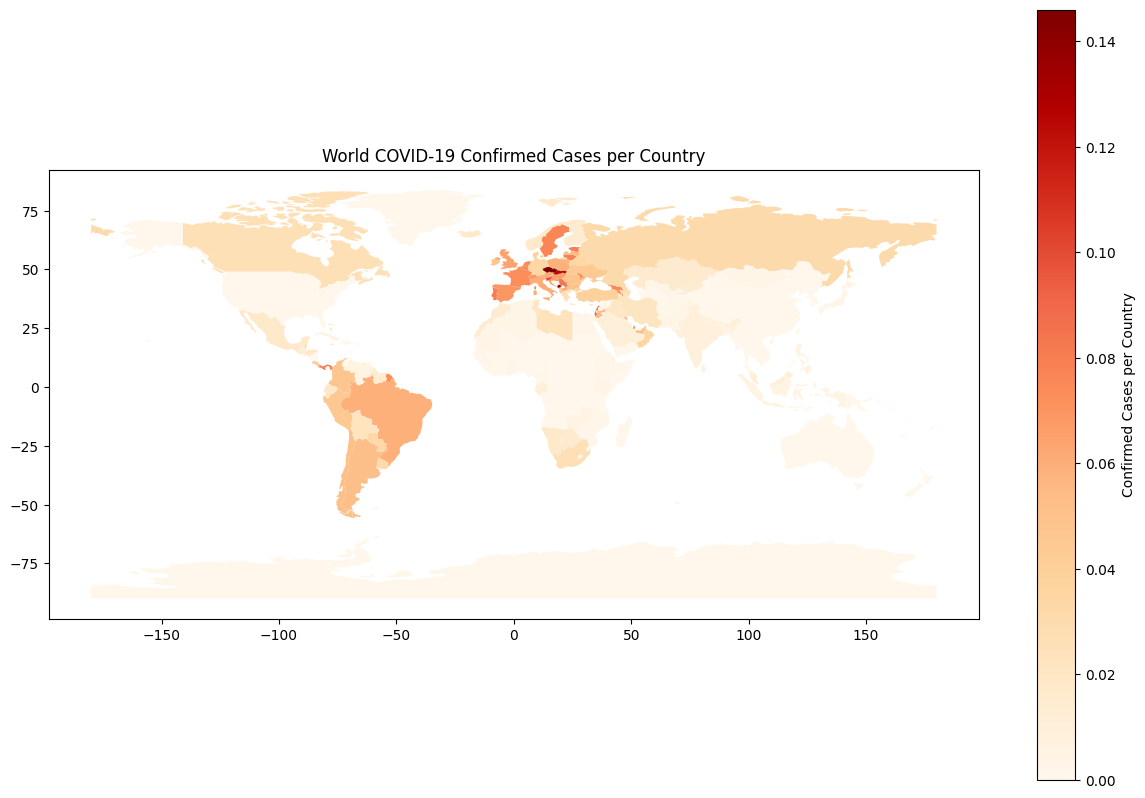

In [75]:
# Load map data (e.g., country geographic data provided by 'naturalearth_lowres')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge 'world' DataFrame with COVID-19 data based on country name.
# Use 'location_with_pop_df' DataFrame but ensure all text is in English.
merged_df = world.merge(location_with_pop_df, left_on='name', right_on='Country_Region', how='left')
merged_df['Confirmed_per_country'] = merged_df['Confirmed_per_country'].fillna(0)

# Visualize map based on confirmed cases per Country
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged_df.plot(column='Confirmed_per_country', ax=ax, legend=True,
               legend_kwds={'label': "Confirmed Cases per Country"},
               cmap='OrRd')
plt.title('World COVID-19 Confirmed Cases per Country')
plt.show()

In [76]:
def plot_bar_chart(x_values, y_values, x_label, y_label, title):
    plt.figure(figsize=(10, 6))
    plt.bar(x_values, y_values, color='skyblue')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


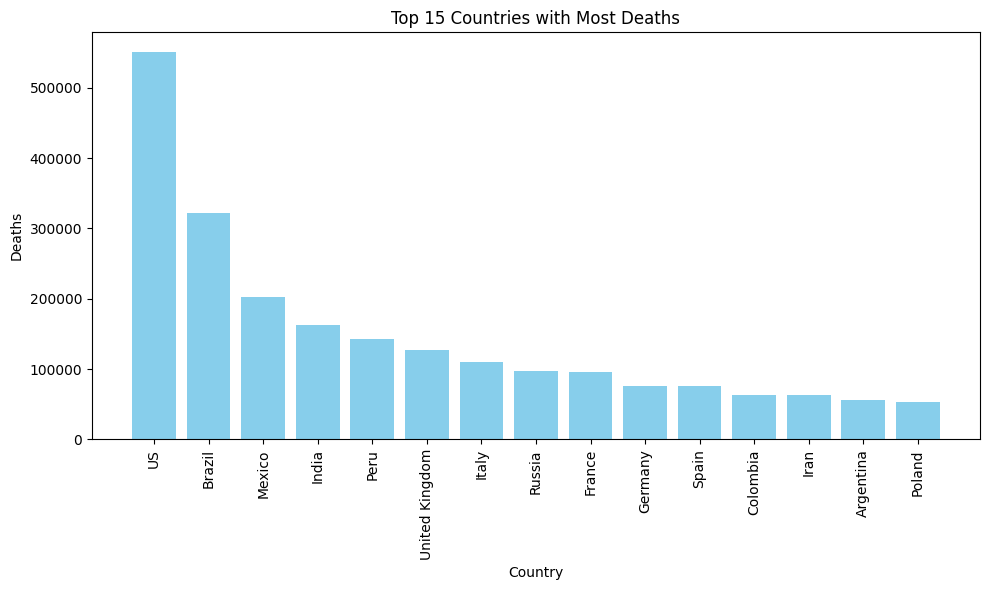

In [77]:
grouped_df = locations_df.groupby('Country_Region')['Deaths'].sum().reset_index()
sorted_df = grouped_df.sort_values(by='Deaths', ascending=False)
top_15_countries = sorted_df.head(15)
plot_bar_chart(top_15_countries['Country_Region'], top_15_countries['Deaths'], 'Country', 'Deaths', 'Top 15 Countries with Most Deaths')

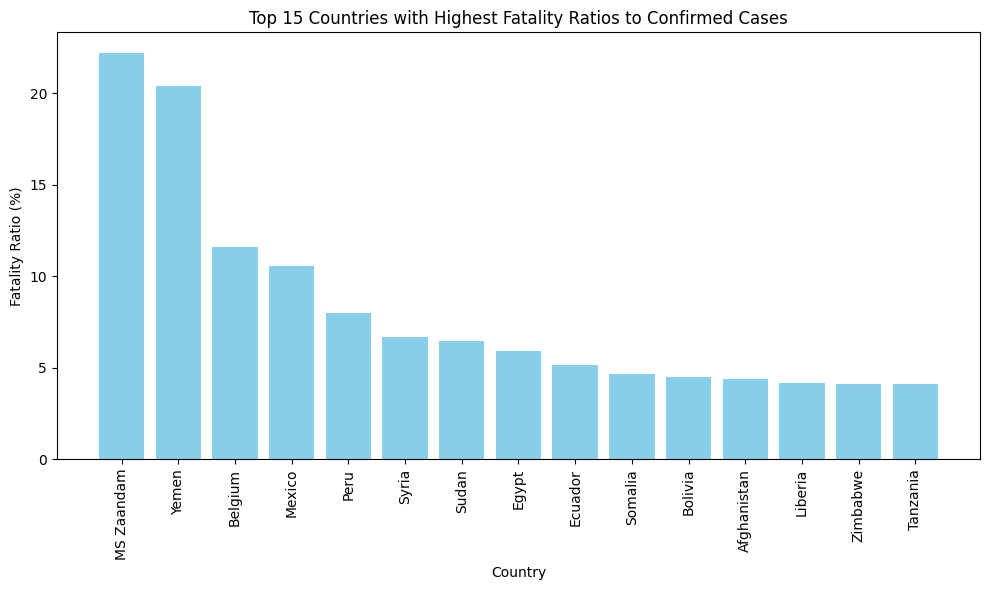

In [78]:
locations_df['Fatality_Ratio'] = (locations_df['Deaths'] / locations_df['Confirmed']) * 100
country_fatality = locations_df.groupby('Country_Region')['Fatality_Ratio'].mean().reset_index()
country_fatality = country_fatality.sort_values(by='Fatality_Ratio', ascending=False).head(15)
plot_bar_chart(country_fatality['Country_Region'], country_fatality['Fatality_Ratio'], 'Country', 'Fatality Ratio (%)', 'Top 15 Countries with Highest Fatality Ratios to Confirmed Cases')

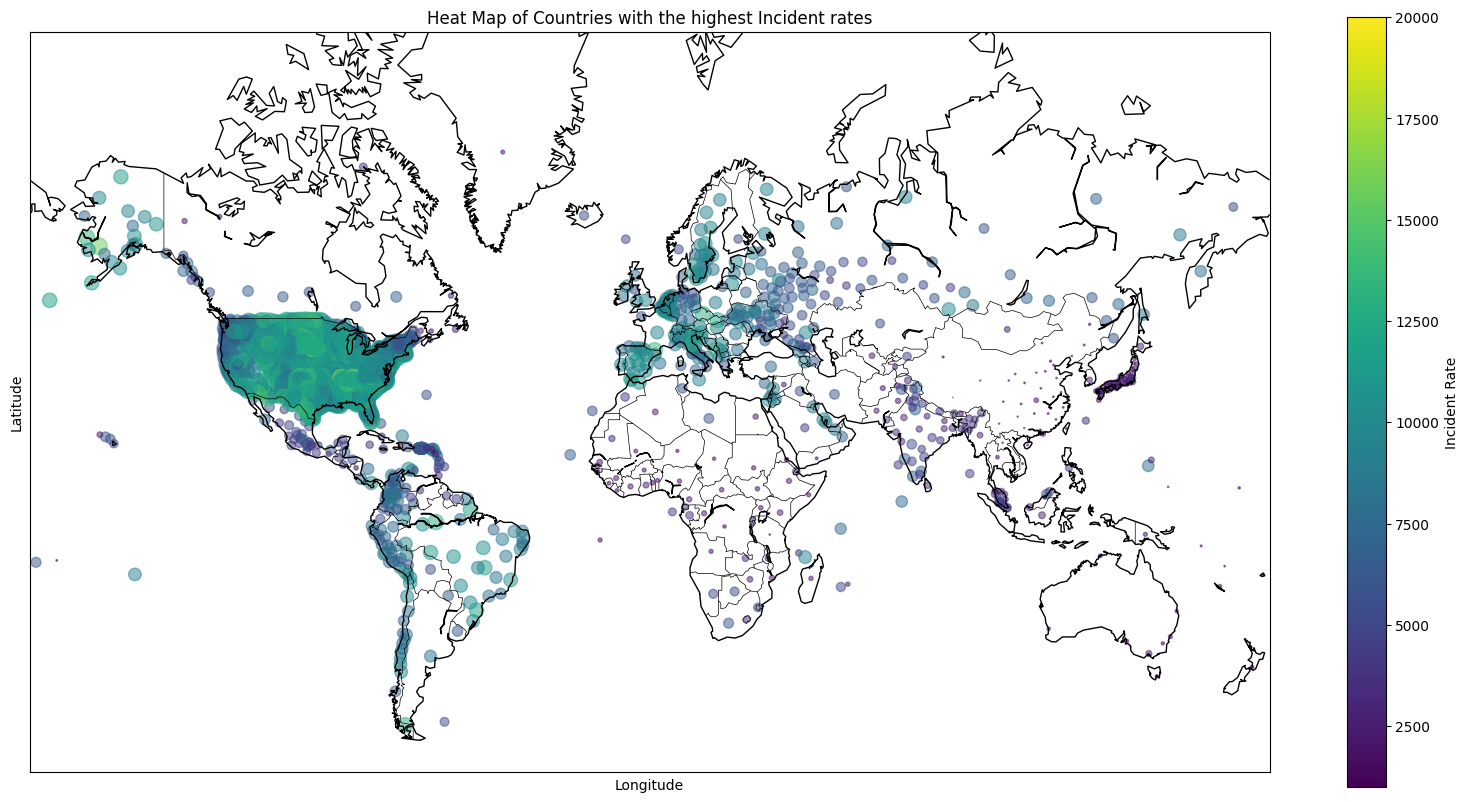

In [79]:
plt.figure(figsize=(20, 10))
plt.title('Heat Map of Countries with the highest Incident rates')

m = Basemap(projection='merc', llcrnrlat=-60, urcrnrlat=80, llcrnrlon=-180, urcrnrlon=180)
m.drawcoastlines()
m.drawcountries()

scatter_sizes = locations_df['Incident_Rate']**0.5
norm = mcolors.Normalize(1000, 20000)
normalized_sizes = norm(scatter_sizes)

# Basemap scatterplot
x, y = m(locations_df['Long_'].values, locations_df['Lat'].values)
scatter_generator = m.scatter(x, y, s=scatter_sizes, c=normalized_sizes, cmap='viridis', alpha=0.5)

plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Colorbar with explicit axis specified
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())  # Explicitly specify the axis using ax=plt.gca()
cbar.set_label('Incident Rate')

plt.show()

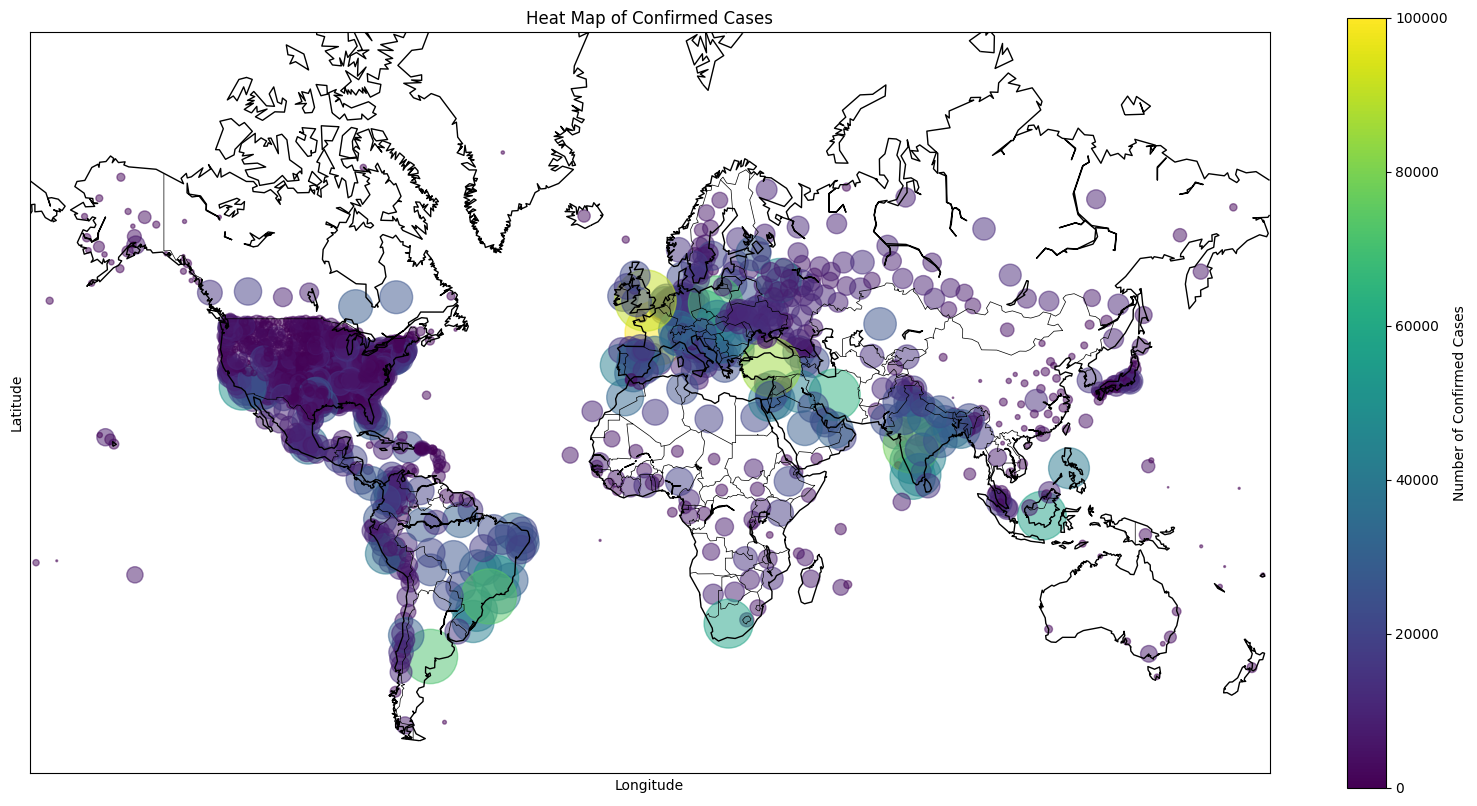

In [80]:
plt.figure(figsize=(20, 10))
plt.title('Heat Map of Confirmed Cases')

m = Basemap(projection='merc', llcrnrlat=-60, urcrnrlat=80, llcrnrlon=-180, urcrnrlon=180)
m.drawcoastlines()
m.drawcountries()

scatter_sizes = locations_df['Confirmed']**0.5
norm = mcolors.Normalize(0, 100000)
normalized_sizes = norm(scatter_sizes)

# Basemap scatterplot for confirmed cases
x, y = m(locations_df['Long_'].values, locations_df['Lat'].values)
scatter_generator = m.scatter(x, y, s=scatter_sizes, c=normalized_sizes, cmap='viridis', alpha=0.5)

plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Colorbar with explicit axis specified
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())  # Explicitly specify the axis using ax=plt.gca()
cbar.set_label('Number of Confirmed Cases')

plt.show()

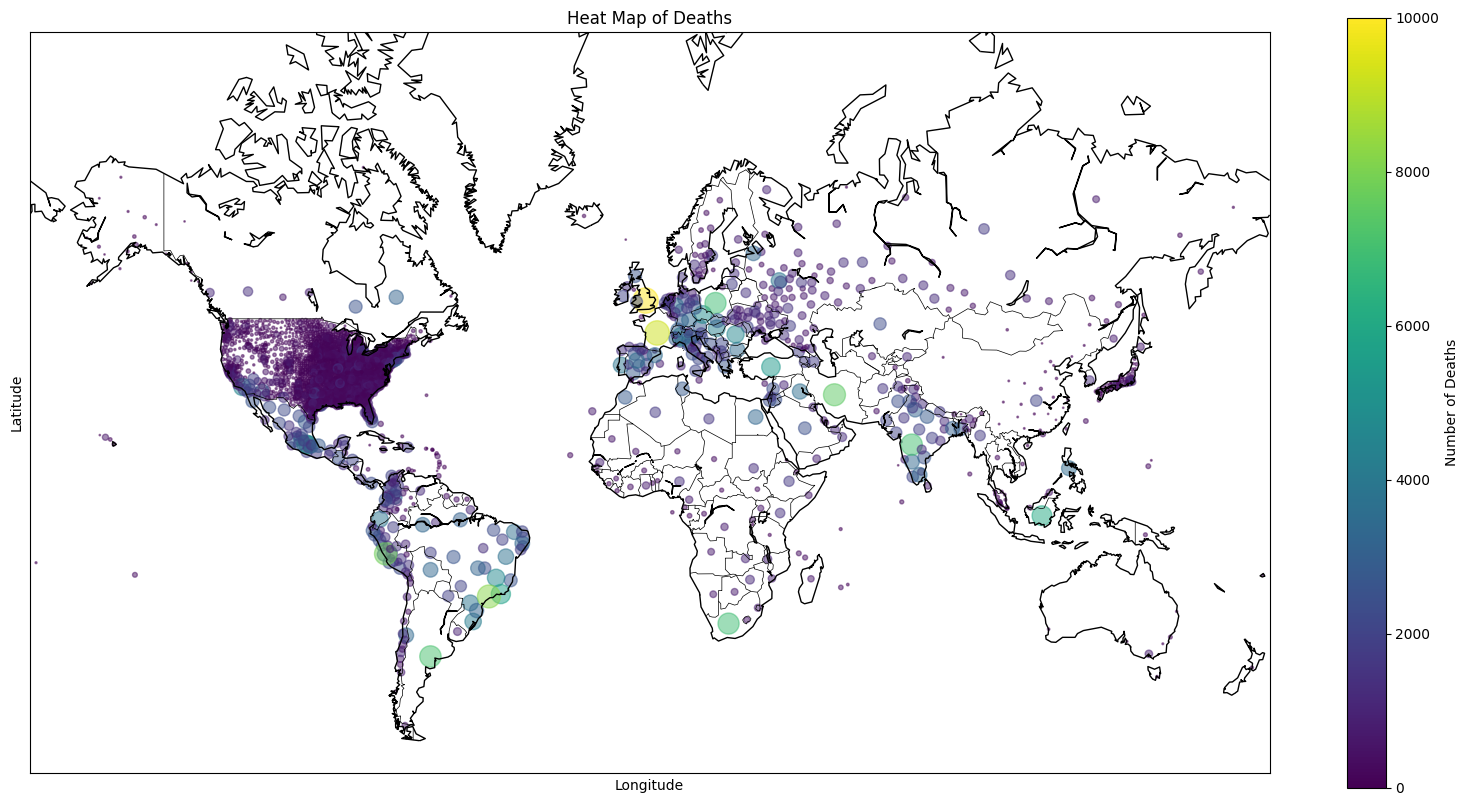

In [81]:
plt.figure(figsize=(20, 10))
plt.title('Heat Map of Deaths')

m = Basemap(projection='merc', llcrnrlat=-60, urcrnrlat=80, llcrnrlon=-180, urcrnrlon=180)
m.drawcoastlines()
m.drawcountries()

scatter_sizes = locations_df['Deaths']**0.5
norm = mcolors.Normalize(0, 10000)
normalized_sizes = norm(scatter_sizes)

# Basemap scatterplot
x, y = m(locations_df['Long_'].values, locations_df['Lat'].values)
scatter_generator = m.scatter(x, y, s=scatter_sizes, c=normalized_sizes, cmap='viridis', alpha=0.5)

plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Colorbar with explicit axis specified
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())  # Explicitly specify the axis using ax=plt.gca()
cbar.set_label('Number of Deaths')

plt.show()

## 2. Data Preprocessing <a class="anchor" id="chapter2"></a>

In [82]:
print("\nMissing values in train dataset:\n", cases_train_df.isnull().sum())



Missing values in train dataset:
 age                       182793
sex                       180362
province                     604
country                        1
latitude                       0
longitude                      0
date_confirmation             51
additional_information    193444
source                     18394
chronic_disease_binary         0
outcome                        0
outcome_group             205846
dtype: int64


In [83]:
cases_train_df['province'] = cases_train_df['province'].fillna('Unknown')
locations_df['Province_State'] = locations_df['Province_State'].fillna('Unknown')

In [84]:
# - Remove the LAST_UPDATE column, it doesnt addmuch 
locations_df = locations_df.drop(['Last_Update'], axis=1)


# - REplace age/sex with -1
cases_train_df = cases_train_df.fillna({'age': -1, 'sex': -1})
cases_test_df = cases_test_df.fillna({'age': -1, 'sex': -1})


In [85]:
#remove outcome_group and additional information

cases_train_df.drop(columns=['additional_information', 'outcome_group'], inplace=True)
cases_test_df.drop(columns=['additional_information', 'outcome_group'], inplace=True)


In [86]:
print("\nMissing values in train dataset after handling:\n", cases_train_df.isnull().sum())


Missing values in train dataset after handling:
 age                           0
sex                           0
province                      0
country                       1
latitude                      0
longitude                     0
date_confirmation            51
source                    18394
chronic_disease_binary        0
outcome                       0
dtype: int64


In [87]:
# Convert 'age' column to numeric type, coerce errors to NaN
cases_train_df['age'] = pd.to_numeric(cases_train_df['age'], errors='coerce')
cases_test_df['age'] = pd.to_numeric(cases_test_df['age'], errors='coerce')

# - Remove unlikely ages from dataset

cases_train_df = cases_train_df[(cases_train_df['age'] >= 0) & (cases_train_df['age'] < 105)]
cases_test_df = cases_test_df[(cases_test_df['age'] >= 0) & (cases_test_df['age'] < 105)]

# - Remove unlikely Long/Lat from dataset

cases_train_df = cases_train_df[(cases_train_df['latitude'] >= -90) & (cases_train_df['latitude'] < 90)]
cases_train_df = cases_train_df[(cases_train_df['longitude'] >= -180) & (cases_train_df['longitude'] < 180)]
cases_test_df = cases_test_df[(cases_test_df['longitude'] >= -180) & (cases_test_df['longitude'] < 180)]
cases_test_df = cases_test_df[(cases_test_df['latitude'] >= -90) & (cases_test_df['latitude'] < 90)] 


# - Remove if province is unknown - The long and lat is missing
locations_df = locations_df.dropna(subset=['Lat', 'Long_'], how='any')

In [88]:
# Combine datasets
combined_df = pd.merge(
    cases_train_df,
    locations_df,
    left_on=['country', 'province'],
    right_on=['Country_Region', 'Province_State'],
    how='inner'
)

# Combine datasets
combined_test_df = pd.merge(
    cases_test_df,
    locations_df,
    left_on=['country', 'province'],
    right_on=['Country_Region', 'Province_State'],
    how='inner'
)

In [89]:
columns_to_drop = ['Lat', 'Long_', 'Province_State', 'Country_Region']
combined_df.drop(columns_to_drop, axis=1, inplace=True)
combined_test_df.drop(columns_to_drop, axis=1, inplace=True)

In [90]:
# Calculate Expected_Mortality_Rate
combined_df['Deaths'] = combined_df['Deaths'].fillna(0)
combined_df['Confirmed'] = combined_df['Confirmed'].fillna(0)
combined_df['Expected_Mortality_Rate'] = combined_df.apply(
    lambda row: (row['Deaths'] / row['Confirmed']) if row['Confirmed'] > 0 else 0,
    axis=1
)

# Calculate Expected_Mortality_Rate
combined_test_df['Deaths'] = combined_test_df['Deaths'].fillna(0)
combined_test_df['Confirmed'] = combined_test_df['Confirmed'].fillna(0)
combined_test_df['Expected_Mortality_Rate'] = combined_test_df.apply(
    lambda row: (row['Deaths'] / row['Confirmed']) if row['Confirmed'] > 0 else 0,
    axis=1
)

In [91]:
print("\nMissing values in combined train dataset:\n", combined_df.isnull().sum())



Missing values in combined train dataset:
 age                         0
sex                         0
province                    0
country                     0
latitude                    0
longitude                   0
date_confirmation          22
source                     62
chronic_disease_binary      0
outcome                     0
Confirmed                   0
Deaths                      0
Recovered                   0
Active                      0
Combined_Key                0
Incident_Rate               0
Case_Fatality_Ratio         0
Fatality_Ratio              0
Expected_Mortality_Rate     0
dtype: int64


In [92]:
cases_train_df = combined_df.copy()
cases_test_df = combined_test_df.copy()

# Check the data after handling missing values
print(cases_train_df.head())
print(cases_test_df.head())


    age     sex    province country  latitude  longitude date_confirmation  \
0  40.0  female  Tamil Nadu   India  13.08362   80.28252        17.05.2020   
1  37.0      -1  Tamil Nadu   India  12.68224   79.98008        04.05.2020   
2  40.0      -1  Tamil Nadu   India   8.96350   77.30821        04.05.2020   
3  27.0    male  Tamil Nadu   India  13.08362   80.28252        13.05.2020   
4  54.0    male  Tamil Nadu   India  10.38486   78.79294        27.05.2020   

                                              source  chronic_disease_binary  \
0  https://stopcorona.tn.gov.in/wp-content/upload...                   False   
1  https://stopcorona.tn.gov.in/wp-content/upload...                   False   
2  https://stopcorona.tn.gov.in/wp-content/upload...                   False   
3  https://stopcorona.tn.gov.in/wp-content/upload...                   False   
4  https://stopcorona.tn.gov.in/wp-content/upload...                   False   

        outcome  Confirmed  Deaths  Recovered   Ac

## 3. Feature Selection <a class="anchor" id="chapter3"></a>

In [93]:
train_df = pd.read_csv('Steps-4-5/data/cases_2021_train_processed_2.csv')
test_df = pd.read_csv('Steps-4-5/data/cases_2021_test_processed_unlabelled_2.csv')

In [94]:
# selected_features = ['age', 'sex', 'chronic_disease_binary', 'latitude', 'longitude', 'Deaths',
#                      'Recovered', 'Confirmed', 'Active', 'Incident_Rate', 'Case_Fatality_Ratio']

selected_features = ['age', 'sex', 'chronic_disease_binary', 'latitude', 'longitude', 'Deaths',
                     'Recovered', 'Confirmed']

In [95]:
numerical_features = ['age', 'latitude', 'longitude', 'Deaths',
                      'Recovered', 'Confirmed', 'Active', 'Incident_Rate', 'Case_Fatality_Ratio']
scaler = StandardScaler()
scaler.fit(cases_train_df[numerical_features])
train_df[numerical_features] = scaler.transform(train_df[numerical_features])
test_df[numerical_features] = scaler.transform(test_df[numerical_features])

## 4. Feature Mapping <a class="anchor" id="chapter4"></a>

In [96]:
# Assuming cases_train_df is your DataFrame with the 'outcome_group' column and you've applied the mapping
# outcome_group_mapping = {
#     'Deceased': 0,
#     'dies': 0,
#     'died': 0,
#     'death': 0,
#     'Hospitalized': 1,
#     'Alive': 1,
#     'stable': 1,
#     'stable condition': 1,
#     'Recovered': 2,
#     'recovered': 2,
#     'discharge': 2,
#     'discharged': 2
# }


In [97]:
train_df['sex'] = pd.Categorical(train_df['sex'])
train_df['sex_code'] = train_df['sex'].cat.codes

test_df['sex'] = pd.Categorical(test_df['sex'])
test_df['sex_code'] = test_df['sex'].cat.codes

In [98]:
train_df['chronic_disease_binary'] = pd.Categorical(train_df['chronic_disease_binary'])
train_df['chronic_disease_binary_code'] = train_df['chronic_disease_binary'].cat.codes

test_df['chronic_disease_binary'] = pd.Categorical(test_df['chronic_disease_binary'])
test_df['chronic_disease_binary_code'] = test_df['chronic_disease_binary'].cat.codes

In [99]:
train_df['province'] = pd.Categorical(train_df['province'])
train_df['province_code'] = train_df['province'].cat.codes

test_df['province'] = pd.Categorical(test_df['province'])
test_df['province_code'] = test_df['province'].cat.codes

In [100]:
train_df['country'] = pd.Categorical(train_df['country'])
train_df['country_code'] = train_df['country'].cat.codes

test_df['country'] = pd.Categorical(test_df['country'])
test_df['country_code'] = test_df['country'].cat.codes

In [101]:
outcome_group_mapping = {'deceased': 0, 'hospitalized': 1, 'nonhospitalized': 2}

train_df['outcome_group_mapped'] = train_df['outcome_group'].map(outcome_group_mapping)

outcome_counts = train_df['outcome_group_mapped'].value_counts()
print("outcome_counts")
print(outcome_counts)

outcome_counts
outcome_group_mapped
1    13241
2     2974
0      997
Name: count, dtype: int64


In [102]:
# cases_train_df['outcome_group'] = pd.Categorical(cases_train_df['outcome_group'])
# cases_train_df['outcome_group_code'] = cases_train_df['outcome_group'].cat.codes

# train_df['outcome_group_mapped'] = train_df['outcome_group'].map(outcome_group_mapping)

In [103]:
# keeping the selected features and 'outcome_group' for the training dataset
# cases_train_df_selected = train_df[selected_features + ['outcome_group_mapped']]
# cases_test_df_selected = test_df[selected_features]

# nan_counts_by_outcome_group = train_df.groupby('outcome_group').apply(lambda x: x.isnull().sum())
# print("NaN count-----------------------")
# print(nan_counts_by_outcome_group)

## 5. Balancing the Classes in the Dataset <a class="anchor" id="chapter5"></a>

In [104]:
print("Original training dataset 'outcome_group' class distribution:")
original_distribution = train_df['outcome_group_mapped'].value_counts()
print(original_distribution)


Original training dataset 'outcome_group' class distribution:
outcome_group_mapped
1    13241
2     2974
0      997
Name: count, dtype: int64


In [105]:
print("\nMissing values in balanced_cases_train_df:\n", train_df.isnull().sum())



Missing values in balanced_cases_train_df:
 age                               0
sex                               0
province                       3621
country                           0
latitude                          0
longitude                         0
date_confirmation                 0
chronic_disease_binary            0
Confirmed                         0
Deaths                            0
Recovered                         0
Active                            0
Incident_Rate                     0
Case_Fatality_Ratio               0
outcome_group                     0
sex_code                          0
chronic_disease_binary_code       0
province_code                     0
country_code                      0
outcome_group_mapped              0
dtype: int64


In [106]:
#-----(BALANCE DATASET CLASSES USING OVERSAMPLING)------  // If country code is -1, that means it is NULL


X = train_df.drop(['outcome_group_mapped'], axis=1)
y = train_df['outcome_group_mapped']


In [107]:
# print("Imbalanced class before: ", y['outcome'].value_counts())

In [108]:
max_samples = max(train_df['outcome_group_mapped'].value_counts())
ros = RandomOverSampler(sampling_strategy={0: max_samples, 1: max_samples, 2: max_samples})
X_res, y_res = ros.fit_resample(X, y)

In [109]:
balanced_distribution = pd.concat([X_res, pd.DataFrame(y_res, columns=['outcome_group_mapped'])], axis=1)
# resampled_data.to_csv('Steps-4-5/result/oversampled_processed_data.csv', index=False)  # Save resulting file to resampled_data.csv 

In [110]:
print(balanced_distribution['outcome_group_mapped'].value_counts())


outcome_group_mapped
1    13241
2    13241
0    13241
Name: count, dtype: int64


## 6. Building Models and Hyperparameter Tuning <a class="anchor" id="chapter6"></a>

### 6.1 KNN <a id="section_6_1"></a>
This is section 2.1

#### 6.1.0 Model Implementation <a id="sub_section_6_1_0"></a>

In [111]:
class KNN:
    def __init__(self, k):
        self.k = k
        self.training_features = None
        self.training_labels = None

    def fit(self, X, y):
        self.training_features = X
        self.training_labels = y

    def euclideanDistance(self, sample1, sample2):
        diff = sample1 - sample2
        squared_diff = diff ** 2
        sum_squared_diff = np.sum(squared_diff, axis=1)
        distance = np.sqrt(sum_squared_diff)
        return distance

    def nearestNeighbors(self, test_sample):
        distances = self.euclideanDistance(self.training_features, test_sample)
        sorted_indices = np.argsort(distances)
        nearest_indices = sorted_indices[:self.k]
        neighbors = [self.training_labels[i] for i in nearest_indices]
        return neighbors
    
    def predict(self, test_set):
        predictions=[]
        for test_sample in test_set:
            neighbors=self.nearestNeighbors(test_sample)
            labels=[sample for sample in neighbors]
            prediction=max(labels,key=labels.count)
            predictions.append(prediction)
        return predictions
    
    def score(self, X, y):
        predictions = self.predict(X)
        return accuracy_score(y, predictions)
    
    def get_params(self, deep=True):
        return {'k': self.k}
    
    def set_params(self, **params):
        self.k = params['k']
        return self


#### 6.1.1 Training KNN Model <a id="sub_section_6_1_1"></a>

In [112]:
outcome_feature = 'outcome_group_mapped'

In [113]:
# X = balanced_distribution[selected_features]
# print("\nMissing values in X:\n", X.isnull().sum())
# y = balanced_distribution[outcome_feature]

In [114]:
balanced_distribution.drop(columns=['sex', 'province', 'country', 'date_confirmation', 'chronic_disease_binary', 'outcome_group'], inplace=True)


In [115]:
# Print all columns of the DataFrame
print("All Columns:")
print(balanced_distribution.columns)

# Calculate the support of class labels
class_support = balanced_distribution[outcome_feature].value_counts()

print("Class Label Support:")
print(class_support)

balanced_distribution.to_csv('result.csv',index=False)

All Columns:
Index(['age', 'latitude', 'longitude', 'Confirmed', 'Deaths', 'Recovered',
       'Active', 'Incident_Rate', 'Case_Fatality_Ratio', 'sex_code',
       'chronic_disease_binary_code', 'province_code', 'country_code',
       'outcome_group_mapped'],
      dtype='object')
Class Label Support:
outcome_group_mapped
1    13241
2    13241
0    13241
Name: count, dtype: int64


In [116]:
# balanced_distribution = balanced_distribution.iloc[14000: 26000]

X = balanced_distribution.iloc[:,:-1].values
y = balanced_distribution.iloc[:, -1].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_val.shape)


(31778, 13)
(7945, 13)


In [117]:
model = KNN(3)

# Train the model
model.fit(X_train, y_train)

# Predictions on the validation set
y_pred = model.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


k_fold = KFold(n_splits=4, shuffle=True, random_state=0)

# Create and fit GridSearchCV object
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=k_fold, scoring='accuracy')
# grid_search.fit(X_train, y_train)


# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_val)

# print("Best Parameters:", grid_search.best_params_)

Accuracy: 0.9025802391441158
Precision: 0.9047580102527977
Recall: 0.9025802391441158


#### 6.1.2 Hyperparameter Tuning <a id="sub_section_6_1_2"></a>

In [118]:

# Define the parameter grid for grid search
param_grid = {
    'k': range(3,5)  # Example parameter range for KNN
}

print("1")
f1_scorer = make_scorer(f1_score, average='macro', labels=[0])  # '0' corresponds to 'deceased'
print("2")

k_fold = KFold(n_splits=4, shuffle=True, random_state=0)

# Create and fit GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=k_fold, scoring={ 'accuracy': 'accuracy', 'f1_macro': 'f1_macro', 'f1_deceased': f1_scorer}, refit='f1_macro')


print("3")
grid_search.fit(X_train, y_train)
print("4")

results = pd.DataFrame(grid_search.cv_results_)
print("5")
# Save the results to a text file
results.to_csv('hyperparameter_tuning_results_rf.txt', index=False)
print("6")
# Report the best parameters and their corresponding scores
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")
print(f"Mean macro F1-score across the validation sets: {results.loc[grid_search.best_index_, 'mean_test_f1_macro']}")
print(f"Mean F1-score on 'deceased' across the validation sets: {results.loc[grid_search.best_index_, 'mean_test_f1_deceased']}")
print(f"Mean overall accuracy across the validation sets: {results.loc[grid_search.best_index_, 'mean_test_accuracy']}")

# Evaluate the best model's performance on the validation dataset
y_val_pred = grid_search.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation set accuracy: {val_accuracy}")

print(f"Best parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)

report = classification_report(y_val, y_pred, target_names=['deceased', 'hospitalized', 'non_hospitalized'])
print(report)


# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)

# print("Best Parameters:", grid_search.best_params_)

1
2
3
4
5
6
Best parameters: {'k': 4}
Best cross-validation score: 0.9023372209639826
Mean macro F1-score across the validation sets: 0.9023372209639826
Mean F1-score on 'deceased' across the validation sets: 0.8662443948264935
Mean overall accuracy across the validation sets: 0.9016930819068913
Validation set accuracy: 0.9039647577092511
Best parameters: {'k': 4}
                  precision    recall  f1-score   support

        deceased       0.84      0.90      0.87      2623
    hospitalized       0.96      0.92      0.94      2664
non_hospitalized       0.92      0.90      0.91      2658

        accuracy                           0.90      7945
       macro avg       0.91      0.90      0.90      7945
    weighted avg       0.91      0.90      0.90      7945



### 6.2 Random Forest <a id="section_6_2"></a>


#### 6.2.0 Model Implementation <a id="sub_section_6_2_0"></a>

#### 6.2.1 Training Model <a id="sub_section_6_2_1"></a>

#### 6.2.2 Hyperparameter Tuning <a id="sub_section_6_2_2"></a>

### 6.3 Naive Bayes Classifier <a id="section_6_3"></a>


#### 6.3.0 Model Implementation <a id="sub_section_6_3_0"></a>

#### 6.3.1 Training Model <a id="sub_section_6_3_1"></a>

#### 6.3.2 Hyperparameter Tuning <a id="sub_section_6_3_2"></a>

## 7. Overfitting <a class="anchor" id="chapter6"></a>

#### 7.1 KNN <a id="section_7_1"></a>

Cycle complete for :  1
Cycle complete for :  1
Cycle complete for :  1
Cycle complete for :  1
Cycle complete for :  2
Cycle complete for :  2
Cycle complete for :  2
Cycle complete for :  2
Cycle complete for :  3
Cycle complete for :  3
Cycle complete for :  3
Cycle complete for :  3


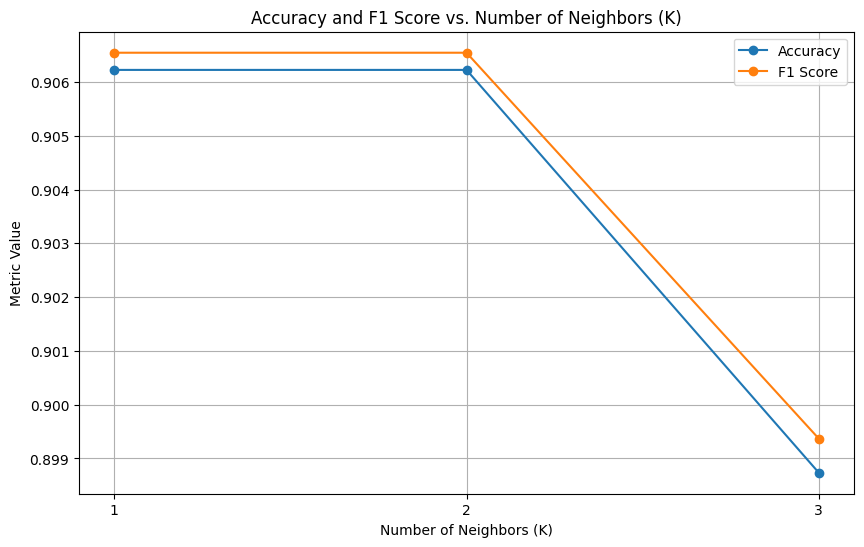

In [121]:
# Define a range of K values to test
k_values = list(range(1, 4))
accuracies = []
f1_scores = []

# Loop through different K values
for k in k_values:
    # Create a KNN model with the current K value
    model = KNN(k)
    
    # Perform KFold cross-validation
    k_fold = KFold(n_splits=4, shuffle=True, random_state=0)
    fold_accuracies = []
    fold_f1_scores = []
    
    for train_indices, val_indices in k_fold.split(X_train):
        X_train_fold, X_val_fold = X_train[train_indices], X_train[val_indices]
        y_train_fold, y_val_fold = y_train[train_indices], y_train[val_indices]
        
        # Train the model
        model.fit(X_train_fold, y_train_fold)
        
        # Predictions on the validation fold
        y_pred_fold = model.predict(X_val_fold)
        
        # Calculate accuracy for this fold
        fold_accuracy = accuracy_score(y_val_fold, y_pred_fold)
        fold_accuracies.append(fold_accuracy)
        
        # Calculate F1 score for this fold
        fold_f1 = f1_score(y_val_fold, y_pred_fold, average='weighted')
        fold_f1_scores.append(fold_f1)
        print("Cycle complete for : ", k)
    
    # Average accuracy and F1 score across folds for this K value
    avg_accuracy = np.mean(fold_accuracies)
    accuracies.append(avg_accuracy)
    
    avg_f1_score = np.mean(fold_f1_scores)
    f1_scores.append(avg_f1_score)

# Plotting the accuracy and F1 score graph
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', label='Accuracy')
plt.plot(k_values, f1_scores, marker='o', label='F1 Score')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Metric Value')
plt.title('Accuracy and F1 Score vs. Number of Neighbors (K)')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()

Cycle complete
Cycle complete
Cycle complete
Cycle complete
Cycle complete
[[2371   77  175]
 [ 203 2431   30]
 [ 289   27 2342]]
0.8991818753933292


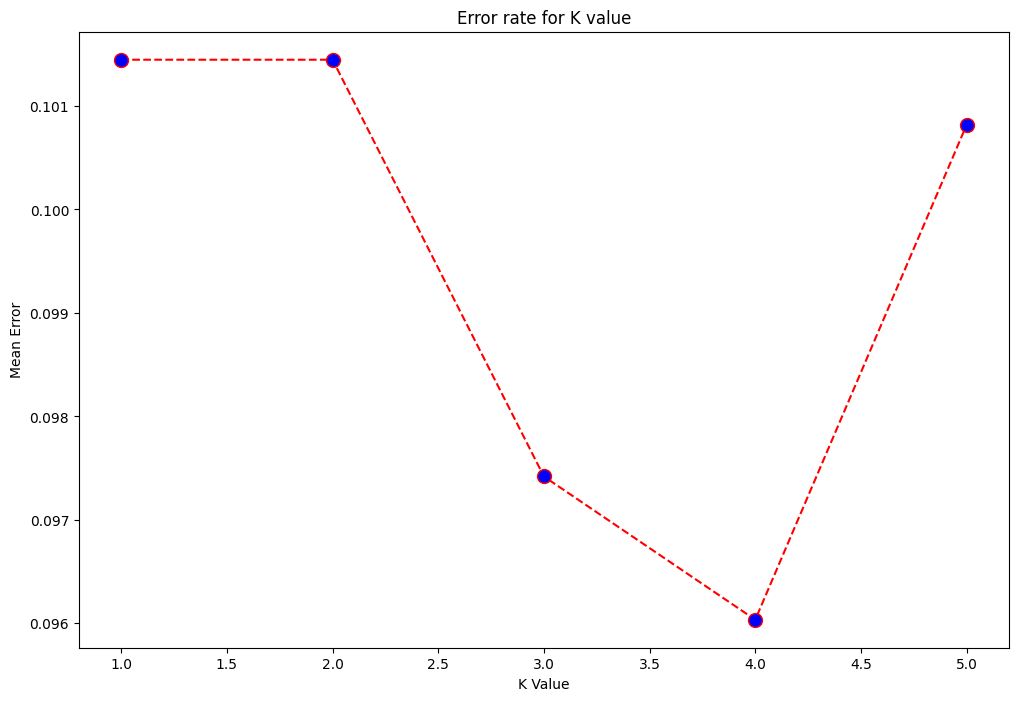

In [126]:
error = []

for i in range(1, 6):
    print("Cycle complete")
    knn = KNN(i)
    knn.fit(X_train, y_train)
    predictions=knn.predict(X_val)#our model's predictions
    error.append(np.mean(predictions != y_val))


cm = confusion_matrix(y_val, predictions) #our model
print(cm)
print(accuracy_score(y_val, predictions)) 

plt.figure(figsize=(12,8))
plt.plot(range(1,6), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title("Error rate for K value")
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.show()

In [ ]:
# Create and train a KNN model with K=1
knn_model_k1 = KNN(n_neighbors=1)
knn_model_k1.fit(X_train, y_train)

# Create and train a KNN model with K=4
knn_model_k4 = KNN(n_neighbors=4)
knn_model_k4.fit(X_train, y_train)

# Predictions on validation data
y_val_pred_k1 = knn_model_k1.predict(X_val)
y_val_pred_k4 = knn_model_k4.predict(X_val)

# Calculate confusion matrices
conf_matrix_k1 = confusion_matrix(y_val, y_val_pred_k1)
conf_matrix_k4 = confusion_matrix(y_val, y_val_pred_k4)

# Plot confusion matrices
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_confusion_matrix(knn_model_k1, X_val, y_val, cmap=plt.cm.Blues, normalize=None)
plt.title('Confusion Matrix (K=1)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(1, 2, 2)
plot_confusion_matrix(knn_model_k4, X_val, y_val, cmap=plt.cm.Blues, normalize=None)
plt.title('Confusion Matrix (K=4)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

#### 7.1 Random Forest <a id="section_7_2"></a>

#### 7.1 Naive Bayes <a id="section_7_3"></a>